# Introduction

# Preparatory analysis

In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [381]:
data = pd.read_csv('data/diabetic_data.csv')

In [382]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

In [383]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [384]:
data.shape

(101766, 50)

In [385]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [386]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [387]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [388]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [389]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [390]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [391]:
#FARLO DOPO ANALISI ESPLORATIVA, ALTRIMENTI ALCUNE OSSERVAZIONI UTILI SI PERDONO

#labels = (data['diag_1'] == '?') | (data['diag_2'] == '?') | (data['diag_3'] == '?')
#data.drop(data[labels].index, inplace=True) # data[~labels] OP

In [392]:
data.shape

(101766, 45)

In [393]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

# Renaiming some columns

To avoid potential failure when using statsmodel, we rename the columns that contains a '-' in their name.

In [394]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

## Changing unique values for some columns

Is this safe for logistic regression?

data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
data.replace('No', 0, inplace=True)
data.replace('Ch', 1, inplace=True)
data.replace('Yes', 1, inplace=True)
data.replace(['Steady', 'Up', 'Down'], [1, 2, 3], inplace=True) #non ottimale

dict = {'[0-10)':0, '[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7, '[80-90)':8, '[90-100)':9}
data.replace(dict, inplace=True)

# Exploratory data analysis

## What is the most frequent readmission type?

In [395]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
<30    0.111599
>30    0.349282
NO     0.539119
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

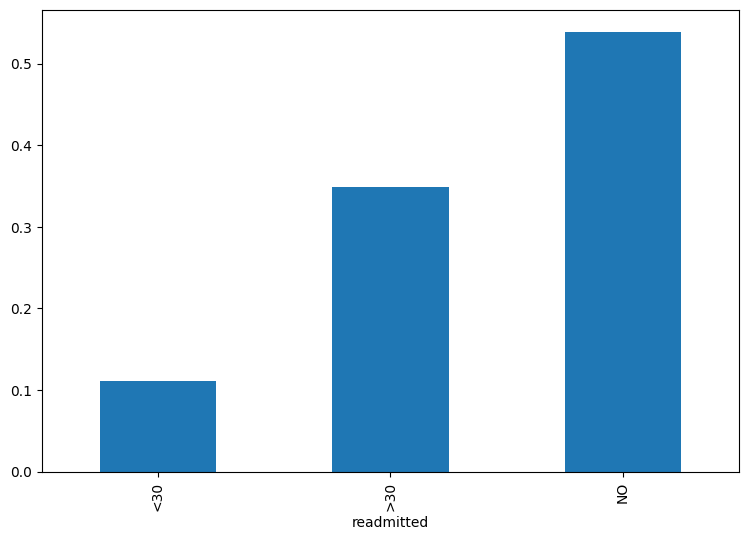

In [396]:
freqs.plot.bar(figsize=(9, 6))

Il 54% dei pazienti non è tornato in ospedale, il 35% è tornato in ospedale in un periodo che supera i 30 giorni e, infine, il restante 11% è tornato entro i 30 giorni. Da questo si evince che le valutazioni effettuate dai medici su #num pazienti si sono rivelate corrette e senza falle. ??

In [397]:
#data['readmitted'].plot.bar()

## What is the distribution of gender between readmissions?

## Distribution of gender

In [398]:
data['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [399]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

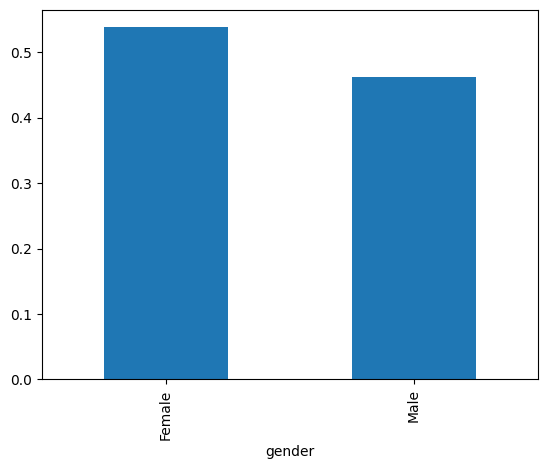

In [400]:
freqs[0:-1].plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [401]:
data['gender'].value_counts().sort_index()

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

## Distribution of gender between readmissions

In [402]:
d = data[['gender', 'readmitted']]

freqs = (d.groupby('gender').value_counts(normalize=True))
print(freqs)

gender           readmitted
Female           NO            0.530782
                 >30           0.356767
                 <30           0.112452
Male             NO            0.548783
                 >30           0.340601
                 <30           0.110615
Unknown/Invalid  NO            1.000000
Name: proportion, dtype: float64


<Axes: xlabel='gender,readmitted'>

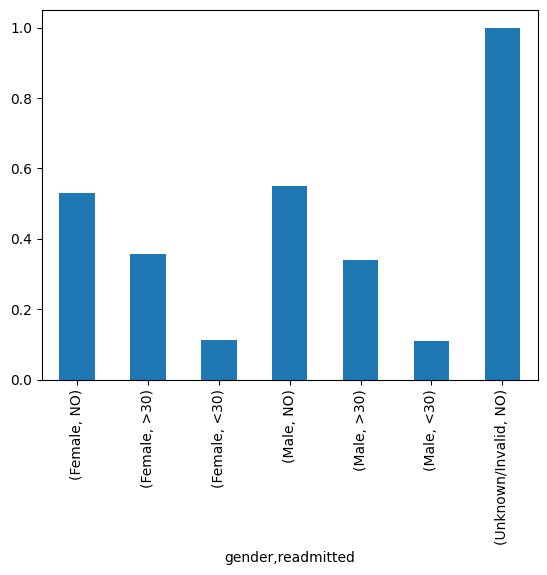

In [403]:
freqs.plot.bar()

## Distribution of age

ecdf = data['age'].value_counts(normalize=True).sort_index().cumsum()

plt.figure(figsize=(12, 8))
plt.title('Empirative Cumulative Distribution Function of Age')
plt.grid()
plt.plot(ecdf.index, ecdf.values)

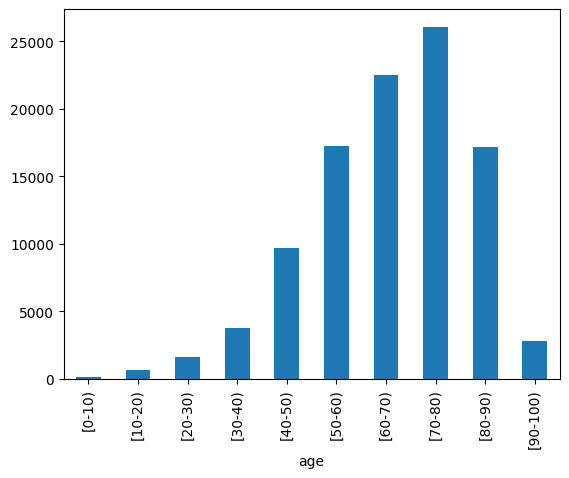

In [404]:
freqs = data['age'].value_counts().sort_index().plot.bar()

In [405]:
cont_table = pd.crosstab(index=data['age'], columns=data['readmitted'], normalize=True)
cont_table

readmitted,<30,>30,NO
age,,,
[0-10),0.000029,0.000255,0.001297
[10-20),0.000393,0.002201,0.004196
[20-30),0.002319,0.005011,0.008952
[30-40),0.004166,0.011664,0.021264
[40-50),0.010092,0.032211,0.052866
[50-60),0.016391,0.058143,0.095032
[60-70),0.024586,0.077600,0.118743
[70-80),0.030157,0.093106,0.132893
[80-90),0.020419,0.061150,0.087416


<Axes: xlabel='age'>

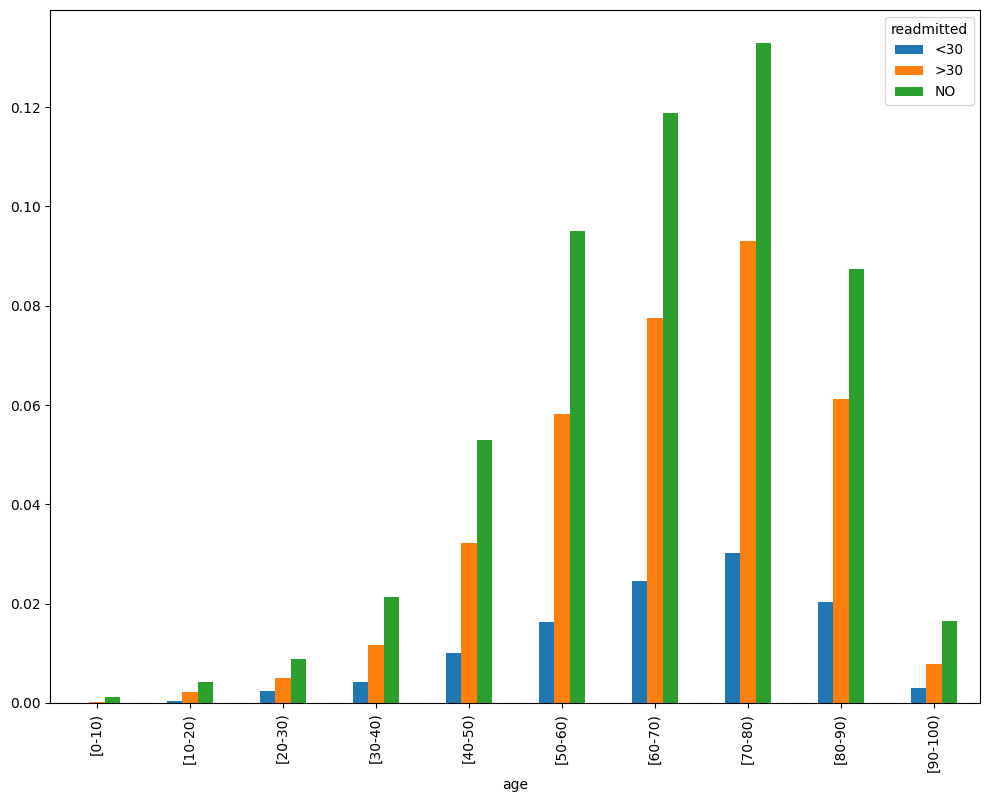

In [406]:
cont_table.plot.bar(figsize=(12, 9))

From the plot above, we can say that the distribution of age is similar between readmisssions types.

<Axes: >

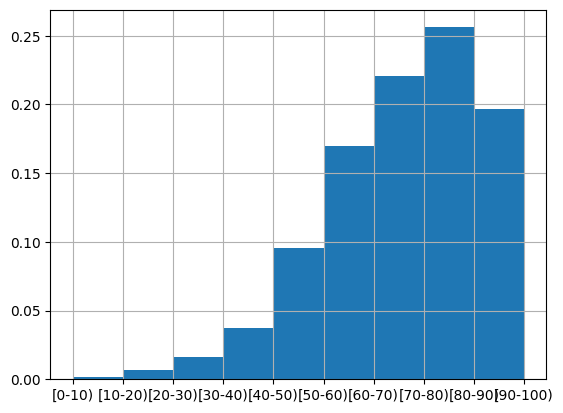

In [407]:
data['age'].hist(density=True, bins = range(0, 10))

....

# Inferential Analysis

## What is the average time in hospital?

In [408]:
mean = data['time_in_hospital'].mean()
print(mean)

4.395986871843248


From the results above, we find that the average time in hospital is 4 days. Is this due to chance or is it statistically significant? Let's run a statistical test and find out.

In [409]:
t, p = stats.ttest_1samp(data['time_in_hospital'], mean)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.0 
Alpha:  0.05


The p value is greater than the significance level, so we cannot reject the null hypothesis. <br>
This means that data do not provide enough evidence to say that the true time in hospital differs from 4 and an half day.

<Axes: >

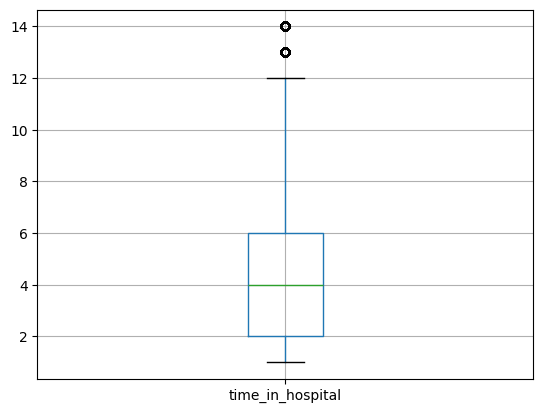

In [410]:
data.boxplot(column=['time_in_hospital'])

From the box plot above, we notice that values 13 and 14 are outliers. The median value is 4 and the third quantile is 6. 

## What is the average time in hospital between readmission classes?

In [411]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

nan


In [412]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.395986871843248


Again, is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [413]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  nan 
Alpha:  0.05


C:\Users\Raffaele\AppData\Local\Temp\ipykernel_23920\2493291851.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t, p = stats.ttest_ind(readmitted, not_readmitted)


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 
Let's study the relationship between time_in_hospital and readmitted, using logistic regression.

Let's use a boxplot to study the distribution of time_in_hospital between readmissions.

<Axes: title={'center': 'time_in_hospital'}, xlabel='readmitted'>

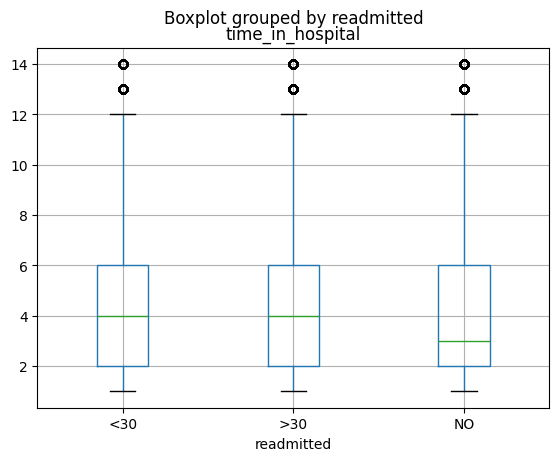

In [414]:
data.boxplot(by='readmitted', column='time_in_hospital') #todo: cambiare titolo

For classes 1 and 2, bloxplots are indentical. For class 0, the median is lower than the other two. This means that the distribution of time_in_hospital for patients of class 0 is not symmetrical.

In [415]:
## Altro?

## Simple logit regression

Let's fit a logistic regressor to study the relationship between time_in_hospital and readmitted. Let's see if an increase of the variable "time_in_hospital" leads to an increase in the probability that a patient will be readmitted or not. 

In [416]:
from statsmodels.formula.api import logit, mnlogit

### Preparing the data

To do this, it is not necessary to use three class of readmissions, instead it sufficient to know if a patient has been readmitted or not.

In [417]:
data['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [418]:
data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_23920\3738235945.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)


In [419]:
view = data.replace({'readmitted': {2: 1}})

In [420]:
view['readmitted'].unique()

array([0, 1])

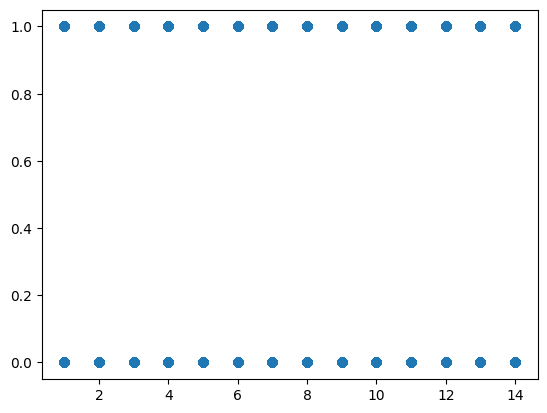

In [421]:
plt.scatter(x=view['time_in_hospital'], y=view['readmitted'])

### Simple logit regression

We can now fit a simple logit regressor

In [422]:
model = logit('readmitted ~ time_in_hospital', view).fit()

Optimization terminated successfully.
         Current function value: 0.688770
         Iterations 4


In [423]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                          Logit   Df Residuals:                   101764
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                0.001903
Time:                        14:06:16   Log-Likelihood:                -70093.
converged:                       True   LL-Null:                       -70227.
Covariance Type:            nonrobust   LLR p-value:                 4.311e-60
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3085      0.011    -27.469      0.000      -0.330      -0.286
time_in_hospital     0.0344      0.002     16.334      0.000       0.030       0.039
====================================================================================
"""

The pseudo-R^2 is very small: the model do not explain well the data.

In [424]:
np.exp(-0.3085)

np.float64(0.7345479521991701)

when time_in_hospital is set to 0, unrealistically, the odds of a patient being readmitted rather than not is 0.73. 

In [425]:
np.exp(0.0344)

np.float64(1.0349985233486143)

Without considering other variables, an extra day in hospital corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of 1.034. That is, if a patient spend an extra day in the hospital, the odds of being readmitted increases by a (1-1.034)*100 = 3.4%

## Simple multivariate logit regressor

In [426]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943557
         Iterations 6


In [427]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                        MNLogit   Df Residuals:                   101762
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                0.001737
Time:                        14:06:17   Log-Likelihood:                -96022.
converged:                       True   LL-Null:                       -96189.
Covariance Type:            nonrobust   LLR p-value:                 2.868e-73
====================================================================================
    readmitted=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5537      0.012    -45.597      0.000      -0.578      -0.530
time_in_hospital     0.0274      0.002     11.967      0.000       0.023       0.032
------------------------------------------------------------------------------------
    readmitted=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.8254      0.019    -98.345      0.000      -1.862      -1.789
time_in_hospital     0.0556      0.003     16.819      0.000       0.049       0.062
====================================================================================
"""

In [428]:
np.exp(0.0556)

np.float64(1.0571747292596514)

In [429]:
# todo: interpretazione

## Multiple logistic regression

### Preparing the data

In [430]:
data['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [431]:
data[data['gender'] == 'Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
30506,98634858,100695042,Other,Unknown/Invalid,[70-80),3,1,1,1,5,...,No,No,No,No,No,No,No,Ch,Yes,0
75551,226864668,60524946,?,Unknown/Invalid,[60-70),1,1,7,1,38,...,No,No,No,No,No,No,No,No,No,0
82573,257364294,78119847,?,Unknown/Invalid,[70-80),1,22,7,8,59,...,No,No,No,No,No,No,No,Ch,Yes,0


In [432]:
data = data.drop(index=[30506, 75551, 82573])

Let's define a function that build the formula automatically

In [433]:
def buildFormula(columns):
    formula = 'readmitted ~ ' + columns[0]
    
    for s in columns[1:-1]:
        formula = formula + ' + ' + s
        
    return formula

In [434]:
view = data.replace({'readmitted': 2}, 1)

### todo: Come trattare la variabile age?

In [435]:
view['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

Let's drop some variables about administrative data

In [436]:
view = view.drop(columns=['encounter_id', 'patient_nbr', 'race', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'examide', 'citoglipton',
                          'diag_1', 'diag_2', 'diag_3'])

Variables "citoglipton" and "examide" have identical values for each observations. so we need to remove them in order to build the model

In [437]:
cols = np.concatenate([[view.columns[0]], view.columns[9:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

# V statistic table

In [438]:
from scipy.stats.contingency import association

In [439]:
def buildVMatrix(df):
    l = []
    cat_vars = df.select_dtypes(include=['uint8']).columns
    v_mat = pd.DataFrame(index = cat_vars, columns= cat_vars)

    for var_one in cat_vars:
        for var_two in cat_vars:
            v = association(pd.crosstab(view[var_one], view[var_two]))
            v_mat.loc[var_one, var_two] = v
            
            if var_one != var_two and v >= 0.7:
                el = [var_one, var_two]
                el.sort()
                
                #usare un set
                if el[1] not in l:
                    l.append(el[1])
    return l
            

In [440]:
vars_to_drop = buildVMatrix(view)

In [441]:
view = view.drop(columns=vars_to_drop)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["feature"] = view.columns
vif["VIF"] = [variance_inflation_factor(view.values, i) for i in range(view.shape[1])]

print(vif.sort_values(by="VIF", ascending=False))

                            feature          VIF
32                      miglitol_No  1338.627304
16                chlorpropamide_No   946.006685
30                      acarbose_No   320.595095
14                   nateglinide_No   146.782459
40           glyburide_metformin_No   142.759144
12                   repaglinide_No    71.928270
18                   glimepiride_No    23.682903
28                 rosiglitazone_No    18.593210
7                  number_diagnoses    17.703230
26                  pioglitazone_No    16.493481
23                     glyburide_No    13.930014
37                       insulin_No    12.568328
21                     glipizide_No    11.604476
47                  diabetesMed_Yes    10.067340
3                   num_medications     8.149918
10                     metformin_No     7.767148
46                        change_No     7.616530
1                num_lab_procedures     6.690112
38                   insulin_Steady     5.025042
0                  t

In [443]:
s = vif.sort_values(by="VIF", ascending=False)

type(s)

pandas.core.frame.DataFrame

In [444]:
view = view.drop(columns=s.iloc[0:19]['feature'].values)

In [445]:
model = logit(buildFormula(view.columns), view).fit()

c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


         Current function value: 0.000000
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [446]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101734
Method:                           MLE   Df Model:                           28
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                   1.000
Time:                        14:07:02   Log-Likelihood:            -0.00054443
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -18.5664     98.031     -0.189      0.850    -210.703     173.570
time_in_hospital                   -0.1375     16.647     -0.008      0.993     -32.766      32.491
num_procedures                     -0.0262     26.148     -0.001      0.999     -51.275      51.222
number_outpatient                  -0.1322     18.589     -0.007      0.994     -36.565      36.301
number_emergency                   -0.0917     22.551     -0.004      0.997     -44.291      44.108
number_inpatient                    0.1482     37.118      0.004      0.997     -72.602      72.899
readmitted                         40.1777    162.659      0.247      0.805    -278.627     358.983
gender_Male                        -0.8849     95.295     -0.009      0.993    -187.660     185.890
metformin_Up                       -0.4171    478.919     -0.001      0.999    -939.081     938.247
repaglinide_Up                      0.0008   1240.240   6.52e-07      1.000   -2430.825    2430.827
nateglinide_Up                     -0.0007   3735.585  -1.98e-07      1.000   -7321.613    7321.611
chlorpropamide_Up                  -0.0036   1.03e+04  -3.49e-07      1.000   -2.02e+04    2.02e+04
glimepiride_Up                      0.0238    700.163    3.4e-05      1.000   -1372.270    1372.317
acetohexamide_Steady                0.0014   1.79e+04   7.62e-08      1.000    -3.5e+04     3.5e+04
glipizide_Up                       -0.2427    568.749     -0.000      1.000   -1114.970    1114.485
glyburide_Up                        0.2542    519.655      0.000      1.000   -1018.252    1018.760
tolbutamide_Steady                 -0.0038   2499.484   -1.5e-06      1.000   -4898.903    4898.895
pioglitazone_Up                    -0.0075    963.260  -7.74e-06      1.000   -1887.962    1887.947
rosiglitazone_Up                    0.0059   1068.137   5.48e-06      1.000   -2093.503    2093.515
acarbose_Up                        -0.0008   5154.605  -1.53e-07      1.000   -1.01e+04    1.01e+04
miglitol_Up                         0.0005    2.1e+04   2.57e-08      1.000   -4.12e+04    4.12e+04
troglitazone_Steady                -0.0017    1.1e+04  -1.55e-07      1.000   -2.15e+04    2.15e+04
tolazamide_Steady                  -0.0092   2484.570  -3.68e-06      1.000   -4869.677    4869.659
tolazamide_Up                      -0.0002   2.74e+04   -7.4e-09      1.000   -5.37e+04    5.37e+04
insulin_Up                          2.8346     94.538      0.030      0.976    -182.457     188.127
glyburide_metformin_Up              0.0043   5947.913   7.15e-07      1.000   -1.17e+04    1.17e+04
glipizide_metformin_Steady          0.0047   6334.722   7.38e-07      1.000   -1.24e+04    1.24e+04
glimepiride_pioglitazone_Steady -9.753e-05   4.98e+04  -1.96e-09      1.000   -9.77e+04    9.77e+04
metformin_rosiglitazone_Steady     -0.0066    1.5e+04  -4.39e-07      1.000   -2.94e+04    2.94e+04
=========================================

### Conclusion: the linear regression model is not a good model to explain data. 

## Backward selection

In [448]:
a = 0.05 #significance level
count = 1
while True:
    p = np.max(model.pvalues)
    if p > a:
        count = count + 1
        #backward selection
        i = np.argmax(model.pvalues)
        view = view.drop(columns=model.pvalues.index[i])
         
        formula = buildFormula(view.columns)
        model = logit(formula, view).fit()
    else:
        break

KeyError: "['glyburide_metformin_Up'] not found in axis"

In [ ]:
print(count, "variables removed")

In [ ]:
model.summary()

# Predictive Analysis

## PCA + logistic regression
## LDA
## Naive Bayes

# Conclusions